<a href="https://colab.research.google.com/github/SNMHZ/YZ_Investor_Profiling/blob/master/YZ%EC%84%B8%EB%8C%80%2C%20%ED%80%80%ED%8A%B8%EB%A1%9C%20%EB%B3%B4%EB%8A%94%20%22%EB%84%88%20%EC%9E%90%EC%8B%A0%EC%9D%84%20%EC%95%8C%EB%9D%BC%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YZ세대, 퀀트로 보는 "너 자신을 알라"

## 0-1. 목차


1.  서론
 - COVID-19, 투자 패러다임의 변화
 - WHY: 왜 YZ세대인가?
 - WHAT : YZ세대의 무엇을 분석할 것인가?
 - HOW : 어떻게 분석할 것인가?
 - WHEN & WHERE : 어디서 온 데이터를 언제 사용할 것인가?

2.   EDA
 - 주문 매체
 - 매도&매수량
 - 고객등급 분포, 등급별 거래량
 - 투자성향 분포
 - 계좌 보유 지속기간
 - 국내/해외투자 비율

3.   K Means Clustering & Profiling
 - features

          ```
          1. 연령
          2. 고객등급
          3. 매도&매수 변화비율
          4. 거래규모
          5. 거래지속기간
          6. 대형주 선호도
          7. 배당주 선호도
          8. 국내/해외 투자 비율
          ```

 - Scaling
 - 적절한 K 찾기
 - Profiling

          ```
            1. 평범한 월급쟁이형
            2. 성공한 직장인형
            3. 야무진 금수저 대학생형
            4. 코로나 뉴비형(대학생ver.)
            5. 코로나 뉴비형(직장인ver.)
          ```

4.  결론

## 0-2. 환경 설정

### 0-2-1. 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

minmaxscaler = preprocessing.MinMaxScaler()
warnings.filterwarnings(action='ignore')

In [ ]:
path = 'NanumGothicEco.ttf'  
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

### 0-2-2. 데이터 로드

In [ ]:
act_info = pd.read_csv("/yz/2_act_info.csv")
cus_info = pd.read_csv("/yz/2_cus_info.csv")
iem_info = pd.read_csv("/yz/2_iem_info.csv")
trd_kr = pd.read_csv("/yz/2_trd_kr.csv")
trd_oss = pd.read_csv("/yz/2_trd_oss.csv")

#### 0-2-2-1. 간단한 전처리

In [ ]:
#종목 코드 데이터에서 공백 제거
iem_cd_drop = []
for i in range(len(iem_info['iem_cd'])):
  iem_cd_drop.append(iem_info['iem_cd'].iloc[i].replace(" ", ""))
  #print('\r'+str(i), end='')
iem_info['iem_cd']=iem_cd_drop

In [ ]:
#종목 한글 이름 데이터에서 공백 제거
iem_krl_drop = []
for i in range(len(iem_info['iem_krl_nm'])):
  iem_krl_drop.append(iem_info['iem_krl_nm'].iloc[i].replace(" ", ""))
  #print('\r'+str(i), end='')
iem_info['iem_krl_nm']=iem_krl_drop

In [ ]:
#종목 코드를 넣으면 한글 종목명으로 돌려줍니다.
def iem_cd_to_nm(code_list):
  m_list = []
  for code in code_list:
    m_list.append( iem_info[iem_info['iem_cd']==code]['iem_krl_nm'].iloc[0] )
  return m_list

In [ ]:
act_cus = pd.merge(act_info, cus_info, on = 'cus_id', how = 'left')
trdkr_act = pd.merge(trd_kr, act_info, on = 'act_id', how = 'left')
trdkr_act_cus = pd.merge(trdkr_act, cus_info, on = 'cus_id', how = 'left')
trdoss_act = pd.merge(trd_oss, act_info, on = 'act_id', how = 'left')
trdoss_act_cus = pd.merge(trdoss_act, cus_info, on = 'cus_id', how = 'left')

yz_info = cus_info[cus_info['cus_age'].isin([20, 25, 30, 35])]
yz_act = act_info[act_info['cus_id'].isin(yz_info['cus_id'])]
yz_trdkr = trd_kr[trd_kr['act_id'].isin(yz_act['act_id'])]
yz_trdoss = trd_oss[trd_oss['act_id'].isin(yz_act['act_id'])]

# 1. 서론

## 1-1. COVID-19, 투자 패러다임의 변화  

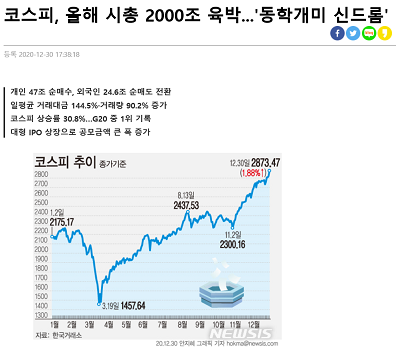

> **"코스피, 올해 시총 2000조 육박.. 동학개미신드롬"**

COVID-19 대유행이 본격적으로 시작된 올해 3월, 저점을 보인것도 잠시  글로벌 통화, 각종 재정 부양책과 함께 개인투자자의 매수세가 급격한 상승을 보이며 주식열풍의 새로운 시작을 알렸습니다.

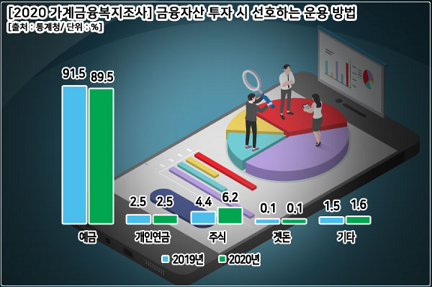

  2020년 금융자산 투자 시 가장 선호하는 운용 방법 통계자료입니다.


 안정성을 이유로 예금을 택했던 가계에서 예금의 선호도는 하락하고<br>
 수익성, 현금화 가능성을 이유로 주식에 손을 드는 흐름이 포착되었죠.

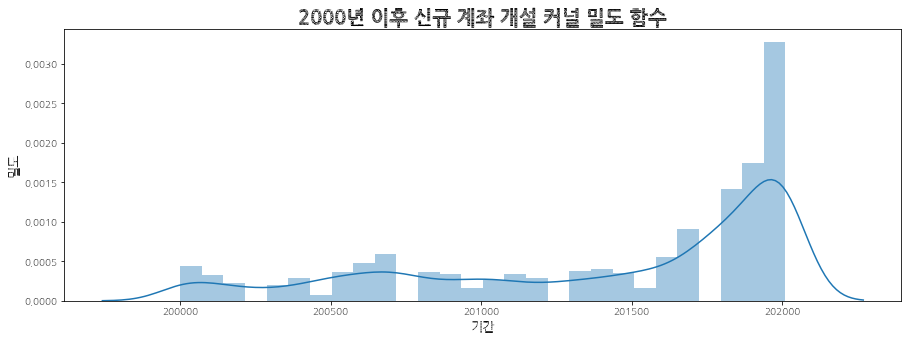

In [ ]:
plt.figure(figsize=(15, 5))
sns.distplot(act_cus[act_cus['act_opn_ym']>=200000]['act_opn_ym'])
plt.title("2000년 이후 신규 계좌 개설 커널 밀도 함수", size = 20, weight='bold')
plt.xlabel("기간",size = 13)
plt.ylabel("밀도",size = 13)
plt.show()

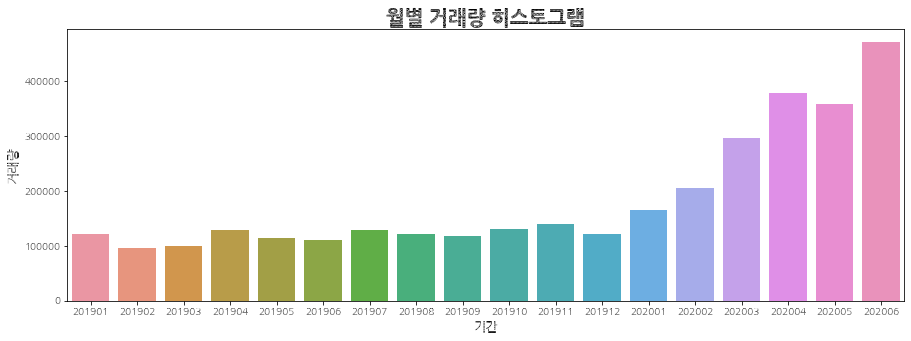

In [ ]:
trdkr_act_cus['orr_dt_monthly']=trdkr_act_cus['orr_dt']//100
plt.figure(figsize=(15, 5))
sns.countplot(trdkr_act_cus['orr_dt_monthly'].sort_values())
plt.title("월별 거래량 히스토그램", size = 20, weight='bold')
plt.xlabel("기간",size = 13)
plt.ylabel("거래량",size = 13)
plt.show()

기간별로 고객들의 계좌 개설 수와 거래량을 시각화한 히스토그램입니다.

한 눈에 봐도 2020년 3월을 기점으로 굉장히 크게 증가한 것을 확인할 수 있죠.

## 1-2. WHY :  왜 YZ세대인가?

> Y세대, Z세대란? 

1990년대 문화를 선도했던 젊은이들을 X세대라 부릅니다.<br>
Y&Z세대는 X세대를 잇는 세대입니다. <br>

2010년, 2020년 문화를 선도하는 현 시대의 2030이 바로 Y세대, Z세대입니다. <br>
따라서, 현 시점의 Y세대를 30대, Z세대를 20대로 정의하겠습니다.


> YZ세대(2030)의 대표적인 특성

```
1.   유행에 민감하다
2.   정보습득에 능숙하다
3.   경제력이 생겨 투자여력이 생기는 세대이다
```

> 그래서 Why 2030?

<br>

1. 유행에 민감
```
근래 투자 이야기를 하는 지인들이 늘어나지 않았나요?
최근의 코로나 사건으로 주식시장에 변동성이 크게 공급되자
YZ세대들이 이에 빠르게 반응하였습니다.
```
<br><br>
2. 정보습득에 능하다
```
성공적인 투자의 요소는 정보력입니다.
ICT에 익숙한 이들은 새로운 정보를 얻는데 익숙합니다.
이로써 자연스레 투자의 진입장벽이 낮아지게 됩니다.
```
<br><br>
3. 경제력이 생겨 투자여력이 생기는 세대이다.
```
점점 낮아지는 경제성장률과 저금리로 투자는 필연이 되었습니다. 
자본 증식을 위해 자연스럽게 예·적금에 비해
매력적인 투자수단인 주식시장으로 유입될 것 입니다.
```


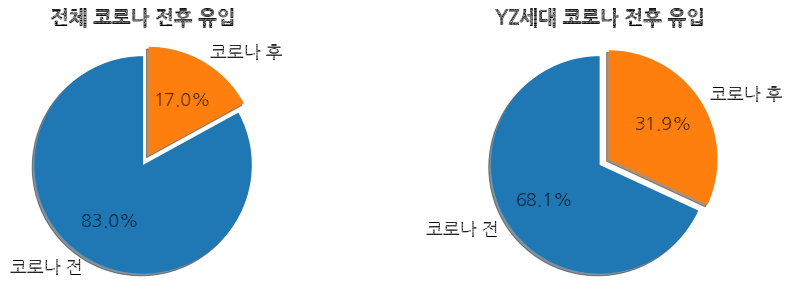

In [ ]:
labels = ['코로나 전', '코로나 후']
explode = (0.0, 0.1,)

fig = plt.figure(figsize=(15, 5))
## 전 연령 코로나 전후 유입
plt.subplot(121)
ratio = [len(act_cus[ act_cus['act_opn_ym']<202003 ]), 
         len(act_cus[ act_cus['act_opn_ym']>=202003 ]), ]
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 18})
plt.title("전체 코로나 전후 유입", size = 20, weight='bold')
## 20대 코로나 전후 유입
plt.subplot(122)
ratio = [len(act_cus[ (act_cus['act_opn_ym']<202003) & (act_cus['cus_age'].isin([20, 25, 30, 35])) ]), 
         len(act_cus[ (act_cus['act_opn_ym']>=202003) & (act_cus['cus_age'].isin([20, 25, 30, 35])) ]), ]
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 18})
plt.title("YZ세대 코로나 전후 유입", size = 20, weight='bold')
plt.show()

코로나 전후로 개설된 전체 계좌 수를 비교한 그래프 입니다.<br>
YZ세대가 코로나라는 사건에 민감하게 반응하여 많이 유입된 모습을 볼 수 있습니다.


위와 같이 아직까지 투자자의 비중 중 다수를 <br>
차지하는 것은 기성세대인 X세대입니다.

하지만 앞에서 YZ세대의 특성을 보았듯, <br>
단기간 내에 주식 투자의 주류가 YZ세대로 넘어올 것이라 예측할 수 있습니다.<br>
 이것이 바로 YZ세대의 투자성향에 우리가 주목해야하는 이유입니다.

## 1-3. WHAT : YZ세대의 무엇을 분석할 것인가?


YZ세대는 개인 개인이 독립적으로, 하나의 키워드로 정의하기 굉장히 힘듭니다.<br>
평범한 20대이기도 하면서 ICT세대의 특징도 모두 가지고 있습니다.<br>
그 특징은 한가지로 정의할 수 없기에, 다각도로 바라보아야 합니다.<br><br>

그렇기에 기존의 '고객투자성향'은 본인이 직접 설문사항을 체크하여 진단하는 검사로, <br>
당연하게도 '자기편향'이 반영될 수 밖에 없다고 판단하였습니다.<br><br>

그래서 우리는 이를 배제하고 데이터를 통해 YZ세대를 한번 더 분해하여 바라보기로 하였습니다.<br><br>


이를 위해 개인의 발자취들로 개인을 특징을 도출하여 <br>
투자자의 진정한 투자성향이 무엇인지 알 수 있도록 분석하였습니다.


## 1-4. HOW : 어떻게 분석할 것인가?



개인의 특징을 파악하여 K-MEANS 알고리즘을 통해 개인들을 분석하여 그룹으로 묶었습니다.<br> 
결론적으로는 저희는 5가지의 투자성향집단을 정의하였습니다.


## 1-5. WHEN & WHERE : 어디서 온 데이터를 언제 사용할 것인가?

우리는 분석을 위해 제공받은 내부데이터와 FnGuide의 Dataguide에서 획득한 외부데이터를 사용하였습니다.<br>

 - 'sizedata.xlsx' : KOSPI, KOSDAQ 시가총액기준 Size 정보
 - 'dividend.xlsx' : KOSPI, KOSDAQ '16~'18년 주당배당금(DPS), '18년 연말 배당수익률 정보


우리는 이를 통해 개인의 KOSPI 대형주 선호도와 배당주 선호도를 도출하였습니다.

# 2. EDA

## 2-1. 주문 매체

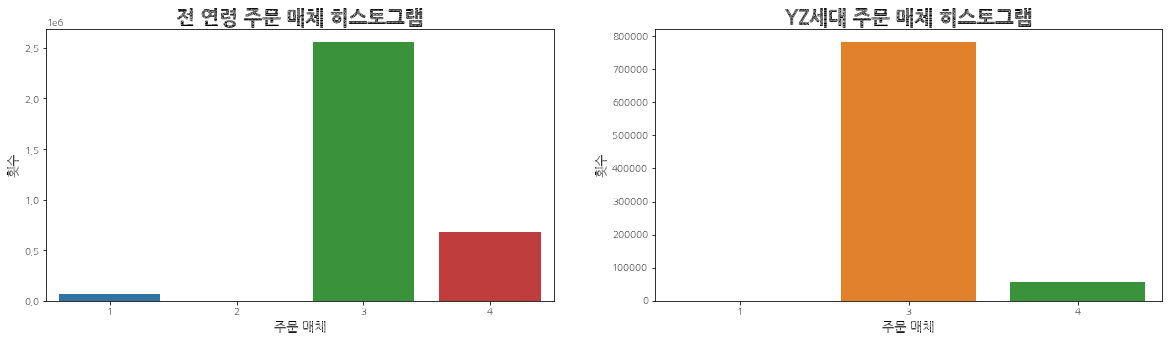

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.countplot(trd_kr['orr_mdi_dit_cd'])
plt.title("전 연령 주문 매체 히스토그램", size = 20, weight='bold')
plt.xlabel("주문 매체",size = 13)
plt.ylabel("횟수",size = 13)
plt.subplot(122)
sns.countplot(trdkr_act_cus[ trdkr_act_cus['cus_age'].isin([20, 25, 30, 35]) ]['orr_mdi_dit_cd'])
plt.title("YZ세대 주문 매체 히스토그램", size = 20, weight='bold')
plt.xlabel("주문 매체",size = 13)
plt.ylabel("횟수",size = 13)
plt.show()

모바일 트레이딩 시스템(MTS)이 주식 투자 수단의 대세로 떠오르고 있는 만큼<br>
Y&Z세대 뿐만 아니라 전 연령에서 MTS 비율이 압도적으로 높은 것을 확인할 수 있습니다.


다만 20대 중 유선단말 이용 고객이 단 한 명도 없다는 것 ,<br>
홈 트레이딩 서비스(HTS) 이용 고객이 전체 연령에 비해 적은 비율을 차지하는 것을 알 수 있죠. 


## 2-2. 매도&매수량

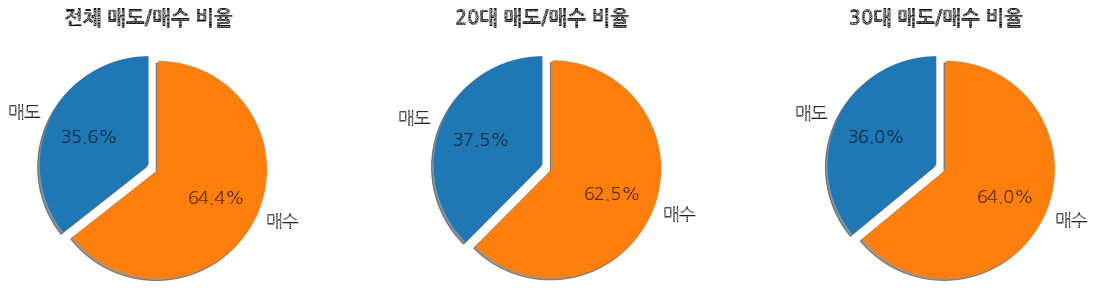

In [ ]:
fig = plt.figure(figsize=(20, 5))
labels = ['매도', '매수']
explode = (0.0, 0.1)
plt.subplot(131)
ratio = [ trdkr_act_cus.groupby('sby_dit_cd').count()['cus_id'][1], trdkr_act_cus.groupby('sby_dit_cd').count()['cus_id'][2] ]
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 18})
plt.title("전체 매도/매수 비율", size = 20, weight='bold')
plt.subplot(132)
ratio = [ trdkr_act_cus[ trdkr_act_cus['cus_age'].isin([20, 25]) ].groupby('sby_dit_cd').count()['cus_id'][1], trdkr_act_cus[trdkr_act_cus['cus_age'].isin([20, 25]) ].groupby('sby_dit_cd').count()['cus_id'][2] ]
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 18})
plt.title("20대 매도/매수 비율", size = 20, weight='bold')
plt.subplot(133)
ratio = [ trdkr_act_cus[ trdkr_act_cus['cus_age'].isin([30, 35]) ].groupby('sby_dit_cd').count()['cus_id'][1], trdkr_act_cus[trdkr_act_cus['cus_age'].isin([30, 35]) ].groupby('sby_dit_cd').count()['cus_id'][2] ]
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 18})
plt.title("30대 매도/매수 비율", size = 20, weight='bold')
plt.show()

모든 연령대에서 매도 거래 내역이 매수 거래 내역보다 많은 결과를 보였습니다.<br>
이는 분할매수/일괄판매의 이유로 예상되며 리스크 관리의 일환으로 받아들여집니다.

YZ세대에서는 전체보다 매수가 약간 적은 모습을 보이는데,<br>
YZ세대가 리스크 관리에 관심이 약간 부족하다고 하였습니다.

이를 수치화 하여 개인별 리스크 관리의 정도를 측정할 수 있을 것으로 생각하였습니다.


## 2-3. 고객등급 분포, 등급별 거래량

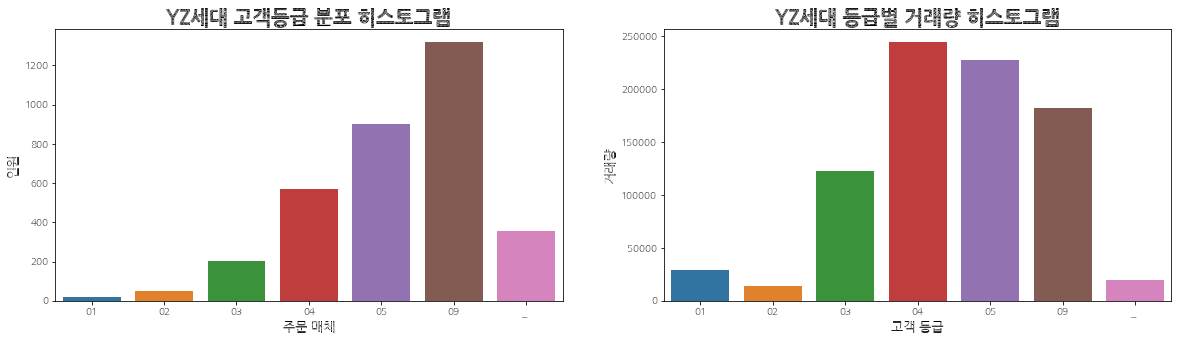

In [ ]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.countplot(cus_info[cus_info['cus_age'].isin([20, 25, 30, 35])]['tco_cus_grd_cd'].sort_values())
plt.title("YZ세대 고객등급 분포 히스토그램", size = 20, weight='bold')
plt.xlabel("주문 매체",size = 13)
plt.ylabel("인원",size = 13)
plt.subplot(122)
sns.countplot(trdkr_act_cus[ trdkr_act_cus['cus_age'].isin([20, 25, 30, 35]) ]['tco_cus_grd_cd'].sort_values())
plt.title("YZ세대 등급별 거래량 히스토그램", size = 20, weight='bold')
plt.xlabel("고객 등급",size = 13)
plt.ylabel("거래량",size = 13)
plt.show()

'등급없음' 이 YZ세대 투자자의 압도적인 비율을 차지하고, <br>
그 다음으로 '블루' , '그린' , 소수의 '로얄' , '골드' ,  '탑클래스'가 존재함을 확인해 볼 수 있습니다.

거래량 면에선 각 고객 수 대비 '탑클래스' , '골드' 등급의 투자가 활발하며 
<br>특히 이는 '그린' 등급에서 가장 큰 차이를 보여주고 있습니다.          

이는 등급별로 확연한 시장 참여도 차이가 나는 것으로 미루어 보아, <br>
고객의 특성을 잘 반영하는 지표로 이해할 수 있습니다.

## 2-4. 투자성향 분포

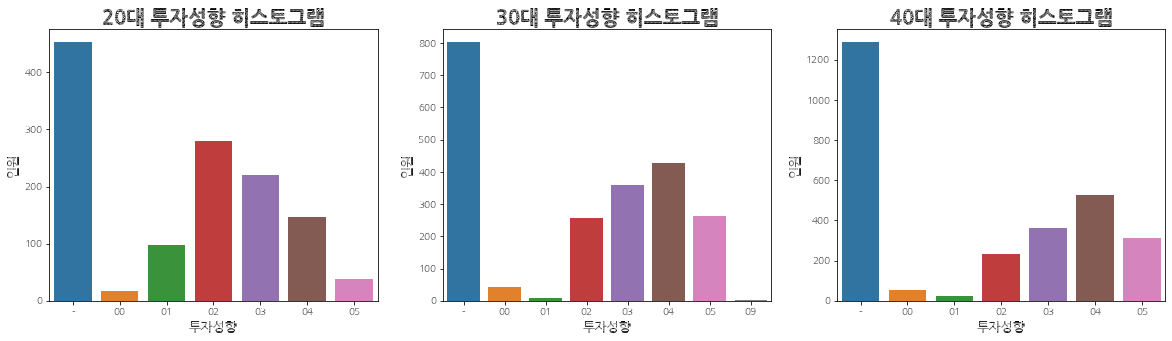

In [ ]:
# 투자성향 분포
# 01: 안정형 / 02: 안정추구형 / 03: 위험중립형 
# 04: 적극투자형 / 05: 공격투자형 
# 09: 전문투자자형 / 00:정보제공미동의
# _: 해당 사항 없음
fig = plt.figure(figsize=(20, 5))
plt.subplot(131)
sns.countplot(cus_info[cus_info['cus_age'].isin([20, 25])]['ivs_icn_cd'].sort_values())
plt.title("20대 투자성향 히스토그램", size = 20, weight='bold')
plt.xlabel("투자성향",size = 13)
plt.ylabel("인원",size = 13)
plt.subplot(132)
sns.countplot(cus_info[cus_info['cus_age'].isin([30, 35])]['ivs_icn_cd'].sort_values())
plt.title("30대 투자성향 히스토그램", size = 20, weight='bold')
plt.xlabel("투자성향",size = 13)
plt.ylabel("인원",size = 13)
plt.subplot(133)
sns.countplot(cus_info[cus_info['cus_age'].isin([40, 45])]['ivs_icn_cd'].sort_values())
plt.title("40대 투자성향 히스토그램", size = 20, weight='bold')
plt.xlabel("투자성향",size = 13)
plt.ylabel("인원",size = 13)
plt.show()

 ‘Y&Z세대는 공격적인 투자성향을 가질 것이다’ 라는 예상과는  달리<br>
 20대 에서는 ‘안정 추구형 ’이 가장 많은 비율을 차지하였습니다.<br> 
 그 다음으로 ‘위험 중립형‘, ‘적극 투자형 ‘, ‘안정형’ 의 분포를 띄었으며 <br>
  예상했던 ‘공격 투자형’은 오히려 가장 적은 비율을 차지했네요. 

30대 에서는 조금 더 적극적인 투자 성향을 띄는 것으로 나타났습니다.<br>
그리고 이는 X세대까지 올라가도 여전히 적극적인 성향을 보이고 있습니다.

우리는 이를 금융 지식 부족에서 기인한 결과라고 판단하였습니다.<br>
또한, 이처럼 투자성향은 개인적인 판단의 결과물이기에 

금융 지식이 상대적으로 부족한 YZ세대에서는 <br>
투자 성향이 고객의 특성을 충분히 반영하지 못한다고 생각하였습니다.

## 2-5. 계좌 보유 지속기간

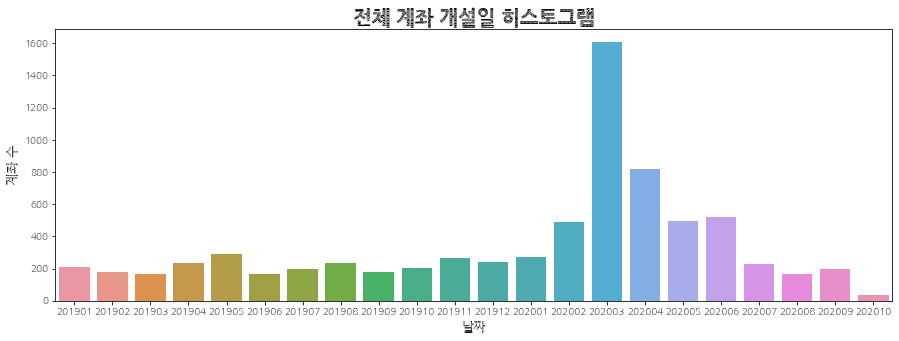

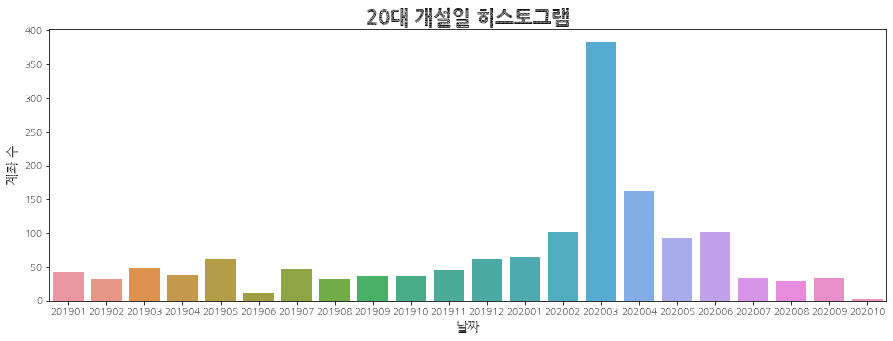

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.countplot( act_cus[ (act_cus['act_opn_ym']>=201900)]['act_opn_ym'])
plt.title("전체 계좌 개설일 히스토그램", size = 20, weight='bold')
plt.xlabel("날짜",size = 13)
plt.ylabel("계좌 수",size = 13)
plt.show()
fig = plt.figure(figsize=(15, 5))
sns.countplot( act_cus[ act_cus['cus_age'].isin([20, 25]) & (act_cus['act_opn_ym']>=201900) ]['act_opn_ym'] )
plt.title("20대 개설일 히스토그램", size = 20, weight='bold')
plt.xlabel("날짜",size = 13)
plt.ylabel("계좌 수",size = 13)
plt.show()

In [ ]:
#활성 계좌 목록
activate_act_info = act_info[act_info['act_id'].isin(set(trd_kr['act_id']))]

#(개설일) - (최근 거래일) 연산으로 거래 기간 구하기
r_trade_list = []
m_len = len(activate_act_info['act_id'])
for i, name in enumerate(activate_act_info['act_id']):
  act_smp = act_info[act_info['act_id'].isin( [ name ] )]['act_opn_ym']
  s_year = act_smp.iloc[0]//100
  s_month = act_smp.iloc[0]%100
  s_day = 1
  s_date = dt.date(s_year, s_month, s_day)

  trd_smp = trd_kr[trd_kr['act_id'].isin( [name] )].sort_values(by='orr_dt', ascending=False)['orr_dt']
  f_year = trd_smp.iloc[0]%100000000//10000
  f_month = trd_smp.iloc[0]%10000//100
  f_day = trd_smp.iloc[0]%100
  f_date = dt.date(f_year, f_month, f_day)

  r_trade_list.append((f_date - s_date).days)
  print('\r'+str(i+1)+'/'+str(m_len)+' '+name+' '+str(r_trade_list[-1]), end='')

10997/10997 cabbab086b730b475d222757d434565cb67e6b6c40505c2c269f99875e636c79 4628

개설일 부터 거래 기간 계산하기

In [ ]:
activate_act_info['rel_trd']=r_trade_list
activate_act_info[activate_act_info['act_id'].isin(act_cus[act_cus['cus_age'].isin([20, 25])]['act_id'])].describe()

,act_opn_ym,rel_trd
count,1316.000000,1316.000000
mean,201888.055471,449.664894
std,195.001973,677.315168
min,199903.000000,2.000000
25%,201810.000000,94.000000
50%,202001.000000,150.000000
75%,202003.000000,592.000000
max,202006.000000,7723.000000


NH투자증권을 이용하는 20대 고객들의 계좌 보유 기간을 분석해본 결과<br> 평균적으로 449일, 약 1년 5개월 정도임을 확인할 수 있었습니다.

 계좌를 개설한 고객의 하위 25%는 약 3달인 94일, 50%는 약 5달인 150일,<br>
 상위 25%는  1년하고 8개월 남짓인 592일임을 알 수 있습니다.

그 중 최단기간  계좌보유 고객의 경우  일주일만에 이탈하였고,<br>
 최장 약 17년 4개월, 7723일간 계좌를 보유한 고객도 있었습니다. 


## 2-6. 국내/해외투자 비율

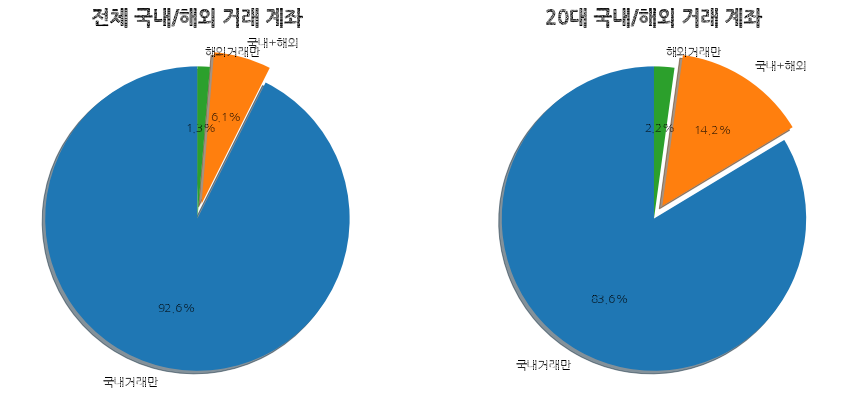

In [ ]:
labels = ['국내거래만', '국내+해외', '해외거래만']
explode = (0.0, 0.1, 0.0)

## 전체 국내 해외 거래 계좌 비율
trdkrset =  set(trd_kr['act_id'])
trdossset = set(trd_oss['act_id'])

fig = plt.figure(figsize=(15, 10))
plt.subplot(121)
ratio = [len(trdkrset-trdossset), 
         len(trdkrset.intersection(trdossset)),
         len(trdossset-trdkrset)]
plt.title("전체 국내/해외 거래 계좌", size = 20, weight='bold')
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12})

## 20대 국내 해외 거래 계좌 비율
plt.subplot(122)
trdkr20set =  set( trdkr_act_cus[trdkr_act_cus['cus_age'].isin([20, 25])]['act_id'])
trdoss20set = set(trdoss_act_cus[trdoss_act_cus['cus_age'].isin([20, 25])]['act_id'])
ratio = [len(trdkr20set-trdoss20set), 
         len(trdkr20set.intersection(trdoss20set)),
         len(trdoss20set-trdkr20set)]
plt.title("20대 국내/해외 거래 계좌", size = 20, weight='bold')
plt.pie(ratio, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12})
plt.show()

전 연령대를 기준으로 포트폴리오 구성 국가 비율을 확인해본 결과 ,     
국내 거래만 하는 투자자들의 비율이 92.6%로 압도적이었고 <br>
해외 거래만 하는 비율이  1.3%, <br>
국내 거래와 해외 거래를 같이 겸하는 투자자들이 6.1%를 차지했습니다 .    

 20대의 경우 <br>
 국내 투자만 진행하는 고객이 83.6%로 9% 감소하였고 <br>
 해외거래만 하는 고객이 2.2%로 전연령에 비해 0.9% 증가, <br>
 국내 거래와 해외 거래를 겸하는 고객이 14.2%로 비율상 두배 이상 증가한 것을 확인할 수있습니다 .


# 3. K-Means Clustering & Profiling

## 3-1. features

> 저희는 EDA 후 다음 8가지 변수들을 각 퍼소나(Persona)별 특성으로 <br>
규정지을 수 있다 판단내려 feature로 삼고, 군집화를 진행해 보았습니다. 

1. **연령**
2. **고객등급**
3. **매도&매수 변화비율**
4. **거래규모**
5. **거래지속기간**
6. **대형주 선호도**
7. **배당주 선호도**
8. **국내/해외 투자 비율**



### 3-1-1. 연령

Y&Z세대를 규정짓는 첫번째 키워드는 아무래도 '나이'죠.

같은 Y&Z세대라 할지라도 세부적으로 '대학생 ,사회초년생, 사회인..' 등 사회적 지위가 다르고, 

이는 각 투자자들의 투자성향, 투자규모에 큰 영향을 미칠 수 있는 요소이기에

주어진 CUS_AGE 데이터에 따라 20-24세/25-29세/30-34세/35-39세 구간을 4가지로 산정하였습니다. 

In [ ]:
#20: 20~24세  0
#25: 25~29세  1
#30: 30~34세  2
#35: 35~39세  3
yz_info['cus_age'].replace({20:0, 25:1, 30:2, 35:3}).value_counts()

3    1207
2     957
1     906
0     348
Name: cus_age, dtype: int64

### 3-1-2. 고객등급

고객 등급도 연령과 마찬가지로 주어진 데이터를 사용,

정규화 편의를 위해 정수형으로 치환하여 사용해 주었습니다. 


In [ ]:
# 01: 탑클래스 (자산1)10억이상 or 수익기여도2) 5백만원 이상)  0
# 02: 골드 (자산3억이상 or 수익기여도 3백만원 이상)           1
# 03: 로얄 (자산1억이상 or 수익기여도 1백만원 이상)           2
# 04: 그린 (자산3천이상 or 수익기여도 5십만원 이상)           3
# 05: 블루 (자산1천이상 or 수익기여도 1십만원 이상)           4
# 09: 등급 없음                                               5
# _: 해당 사항 없음                                           6
yz_info['tco_cus_grd_cd'].replace({'01':0, '02':1, '03':2, '04':3, '05':4, '09':5, '_ ':6}).value_counts()

5    1320
4     900
3     571
6     357
2     203
1      49
0      18
Name: tco_cus_grd_cd, dtype: int64

연령 및 고객 등급은 제공된 데이터를 단순히 임의의 정수형으로 치환하여 사용합니다.

### 3-1-3. 매도&매수 변화비율
앞서 본 '2-2. 매도&매수량' 분석에서 
어느정도 분할매수, 일괄매도의 투자 흐름을 읽을 수 있었습니다 

포트폴리오 리스크를 최소화 시키기 위한
기초중의 기초, '분할매수','분할매도'법을 
잘 실천하는 투자자들도 있고 , 이에 미숙해 '일괄매수', '일괄매도'를 하는 투자자들도 
있겠죠.

이에 착안, feature로 적용시키기 위해 분할 매수&매도(또는 일괄 매수&매도)의 정도를 수치화 

(매도량과 매수량의 차) 나누기 {전체거래량(매수량+매도량)}

(#매도량과 매수량의 차이는 음수값이 뜰수도 있기에 절댓값 처리 해주었습니다.)

0에 가까울수록 분할매수/매도를 하지 않고, <br>
1에 가까울소록 일괄매수/매도를 한다고 판단할 수 있습니다.



In [ ]:
msmd_list = []
for k, name in enumerate(yz_act['act_id']):
  ms_sum = 0 #매수 총 합
  sample_trdkr = yz_trdkr[yz_trdkr['act_id']==name]
  for i in range(len(sample_trdkr)):
    #매수일 경우
    if sample_trdkr['sby_dit_cd'].iloc[i]==1:
      ms_sum+=1
  #ms_sum/(len(sample_trdkr)-ms_sum)
  print('\r'+str(k), end='')
  #거래기록 없는 경우
  if (len(sample_trdkr))==0:
    msmd_list.append(np.NaN)
  #매수 or 매도만 있는 경우
  elif ms_sum==0 or (len(sample_trdkr)-ms_sum)==0:
    msmd_list.append(0)
  else:
    msmd_list.append( abs((len(sample_trdkr)-ms_sum-ms_sum))/len(sample_trdkr) )

6222

In [ ]:
yz_act['msmd']=msmd_list

YZ세대가 가진 모든 계좌에 대하여 매수&매도 비율을 계산하여 추출합니다.

In [ ]:
cus_msmd=[]
for cus_name in yz_info['cus_id']:
  cus_msmd.append(yz_act[yz_act['cus_id']==cus_name]['msmd'].mean())

In [ ]:
yz_info['msmd']=cus_msmd
yz_info.head(3)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,msmd
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-,0.000000
1261,a2e2aef34dadc59d14b62017832a5bd568b7062039eef2...,1,35,11,03,05,0.218884
1262,7d8317e7cbd1ab353c113627212bead7d03692343bf5ad...,1,35,27,09,04,0.698925


YZ세대 개인별로 가진 계좌를 확인하여 위에서 구한 매수&매도 비율의 평균을 구해 개인 특징으로 사용합니다.<br>
휴면 계좌는 NaN값으로, 평균 연산에 포함되지 않습니다.

### 3-1-4. 거래규모

한번에 사고 파는 규모를 계산한 특징입니다.

투자에 얼마나 적극적인지 확인할 수 있는 지표로 생각하여 선택하였습니다.

개인 1회당 거래 규모들의 평균입니다.

In [ ]:
volume_vec_list = []
for k, name in enumerate(yz_act['act_id']):
  volume_vec = []
  sample_trdkr = yz_trdkr[yz_trdkr['act_id']==name]
  for i in range(len(sample_trdkr)):
    volume_vec.append(sample_trdkr['cns_qty'].iloc[i]*sample_trdkr['orr_pr'].iloc[i])
  print('\r'+str(k), end='')
  volume_vec_list.append(volume_vec)

6222

YZ세대가 가진 모든 계좌에 대하여 거래 규모 벡터를 계산하여 추출합니다.

In [ ]:
volume_ave_list=[]
for volume_vec in volume_vec_list:
  if len(volume_vec)!=0:
    volume_ave_list.append( sum(volume_vec)/len(volume_vec) )
  else:
    volume_ave_list.append(np.NaN)

In [ ]:
yz_act['volume_avg']=volume_ave_list

각 거래 규모 벡터의 평균을 구합니다. 다만 거래 기록이 없는 경우 NaN을 넣어줍니다.

In [ ]:
cus_volume_mean=[]
for cus_name in yz_info['cus_id']:
  cus_volume_mean.append(yz_act[yz_act['cus_id']==cus_name]['volume_avg'].mean())

In [ ]:
yz_info['cus_volume']=cus_volume_mean
yz_info.head(3)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,msmd,cus_volume
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-,0.000000,1.365000e+07
1261,a2e2aef34dadc59d14b62017832a5bd568b7062039eef2...,1,35,11,03,05,0.218884,5.744614e+06
1262,7d8317e7cbd1ab353c113627212bead7d03692343bf5ad...,1,35,27,09,04,0.698925,9.781258e+04


YZ세대 개인별로 가진 계좌를 확인하여 위에서 구한 계좌별 거래 규모의 평균을 구해 개인 특징으로 사용합니다.<br>
휴면 계좌는 NaN값으로, 평균 연산에 포함되지 않습니다.

### 3-1-5. 거래지속기간
앞서 말한 바, 2020년 3월을 기점으로 Y&Z세대의 대거 유입이
앞으로의 투자 패러다임을 이끌어갈 큰 변수라는 사실은 더이상
논하기 입아픈 사실입니다. 하지만 이러한 이유로 COVID-19 이후 유입된 NB(New Boy)에만 초점을 맞춘채 프로파일링을 진행하기엔, '진입률'이 압도적이었을 뿐 Y&Z 투자자 중 기존의 OB(Old Boy) 고객수가 압도적으로 많다는 점 또한 지나칠 수 없는 사실이죠.  

이를 위해 계좌 개설일을 파악, NB인가 OB인가를 가를 수 있는 feature가 필요하다 판단, 이를 기반으로 코로나로 인한 新유입층인 NB의 투자성향과 기존 OB의 
특성을  명백히, 세부적으로  분석해보려 합니다. 

In [ ]:
gr_list = []
m_len = len(yz_act['act_id'])
for i, name in enumerate(yz_act['act_id']):
  sample_act = act_info[act_info['act_id'].isin( [ name ] )]
  s_year = sample_act['act_opn_ym'].iloc[0]//100
  s_month = sample_act['act_opn_ym'].iloc[0]%100
  s_day = 1
  s_date = dt.date(s_year, s_month, s_day)

  sample_trdkr = yz_trdkr[yz_trdkr['act_id'].isin( [name] )]
  if len(sample_trdkr)==0:
    gr_list.append(0)
    continue
  f_year = sample_trdkr.sort_values(by='orr_dt', ascending=False)['orr_dt'].iloc[0]%100000000//10000
  f_month = sample_trdkr.sort_values(by='orr_dt', ascending=False)['orr_dt'].iloc[0]%10000//100
  f_day = sample_trdkr.sort_values(by='orr_dt', ascending=False)['orr_dt'].iloc[0]%100
  f_date = dt.date(f_year, f_month, f_day)

  gr_list.append((f_date - s_date).days)
  print('\r'+str(i+1)+'/'+str(m_len)+' '+name+' '+str(gr_list[-1]), end='')

6208/6223 4194884a17658d1bffe661a2b270032f0219d37630f8a9971f3193a282455efd 1833

In [ ]:
yz_act['gr_date']=gr_list

YZ세대가 가진 모든 계좌에 대하여 거래 지속일을 구합니다. (계좌 개설일) - (마지막 거래일)을 사용합니다.

In [ ]:
cus_gr=[]
for cus_name in yz_info['cus_id']:
  cus_gr.append(yz_act[yz_act['cus_id']==cus_name]['gr_date'].max())

In [ ]:
yz_info['gr_date']=cus_gr
yz_info.head(3)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,msmd,cus_volume,gr_date
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-,0.000000,1.365000e+07,6328
1261,a2e2aef34dadc59d14b62017832a5bd568b7062039eef2...,1,35,11,03,05,0.218884,5.744614e+06,120
1262,7d8317e7cbd1ab353c113627212bead7d03692343bf5ad...,1,35,27,09,04,0.698925,9.781258e+04,621


개인이 가진 계좌를 확인하여 가장 큰 값을 특징으로 사용합니다.

### 3-1-5. 대형주 선호도

저희는 투자성향을 신뢰성이 떨어지는 지표라 판단했기에 이를 보완할 필요성이 있었습니다.

그래서 거래 기록과 연관

In [ ]:
yz_trdkr_cd_list = []
for i in range(len(yz_trdkr)):
  yz_trdkr_cd_list.append( yz_trdkr['iem_cd'].iloc[i].replace(" ", ""))
  print('\r'+str(i), end='')
yz_trdkr['iem_cd']=yz_trdkr_cd_list

838619

전처리 과정으로, 종목 코드 뒤쪽의 공백을 제거해 줍니다.

In [ ]:
sizedata = pd.read_excel("https://github.com/SNMHZ/YZ_Investor_Profiling/raw/master/ext_data/sizedata.xlsx")
daehyung_list= []
for k, name in enumerate(sizedata.columns):
  sample_set = set(sizedata[name])
  if len(sample_set)==1 and sample_set.pop()=='코스피 대형주':
    daehyung_list.append(name)
  print('\r'+str(k), end='')

3046

FnGuide사의 DataGuide에서 획득한 코스피 대형주 정보를 스크린합니다.<br>
19년 1월 ~ 20년 6월까지 코스피 200 안쪽 위치를 지킨 종목만 얻어냅니다.

In [ ]:
dh = pd.DataFrame( [yz_trdkr[yz_trdkr['iem_cd'].isin(daehyung_list)]['act_id'].value_counts().index, yz_trdkr[yz_trdkr['iem_cd'].isin(daehyung_list)]['act_id'].value_counts().values], index=['act_id', 'daehyung']).transpose()
dh.head(3)

,act_id,daehyung
0,cbce6477da62e95ace2199a28bf3c42c2aaadfdbaa94ef...,1977
1,e47baa7c5e6040e14a951281e9278c2f8e1e6ecea38b83...,1242
2,3314910191153b6045fb62ef26a7b009f4e4435756b4ad...,1130


In [ ]:
yz_act = yz_act.merge(dh, how='left', on='act_id')
yz_act['daehyung'] = yz_act['daehyung'].fillna(0)

계좌별로 코스피 대형주 거래 횟수를 얻어 YZ세대 계좌 정보에 합병합니다.

In [ ]:
cus_daehyung=[]
for cus_name in yz_info['cus_id']:
  cus_daehyung.append(yz_act[yz_act['cus_id']==cus_name]['daehyung'].sum())

In [ ]:
yz_info['daehyung']=cus_daehyung
yz_info.head(3)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,msmd,cus_volume,gr_date,daehyung
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-,0.000000,1.365000e+07,6328,0
1261,a2e2aef34dadc59d14b62017832a5bd568b7062039eef2...,1,35,11,03,05,0.218884,5.744614e+06,120,6
1262,7d8317e7cbd1ab353c113627212bead7d03692343bf5ad...,1,35,27,09,04,0.698925,9.781258e+04,621,4


개인이 가진 계좌를 확인하여 거래 횟수를 모두 합쳐 특징으로 사용합니다.

### 3-1-7. 배당주 선호도

In [ ]:
dividend = pd.read_excel("https://github.com/SNMHZ/YZ_Investor_Profiling/raw/master/ext_data/Dividend.xlsx", index_col=0)
dividend = dividend.drop(columns=['Unnamed: 1']).dropna(axis=1)
baedang_list = []
for name in dividend.columns:
  temp=0
  count=0
  for row in dividend.index:
    if temp > dividend[name][row]:
      break
    else:
      count+=1
      temp=dividend[name][row]
  if count==3:
    baedang_list.append(name)

대형주처럼 배당주도 스크린합니다.<br>
19년 1월 ~ 20년 6월 동안의 거래 기록을 이용하므로,<br>
16~18 DPS 감소가 없고, 2018 배당수익률 5% 이상인 종목을 선별합니다.

In [ ]:
bd = pd.DataFrame( [yz_trdkr[yz_trdkr['iem_cd'].isin(baedang_list)]['act_id'].value_counts().index, yz_trdkr[yz_trdkr['iem_cd'].isin(baedang_list)]['act_id'].value_counts().values], index=['act_id', 'baedang']).transpose()
yz_act = yz_act.merge(bd, how='left', on='act_id')
yz_act['baedang'] = yz_act['baedang'].fillna(0)

cus_baedang=[]
for cus_name in yz_info['cus_id']:
  cus_baedang.append(yz_act[yz_act['cus_id']==cus_name]['baedang'].sum())
yz_info['baedang']=cus_baedang
yz_info.head(3)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,msmd,cus_volume,gr_date,daehyung,baedang
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-,0.000000,1.365000e+07,6328,0,0
1261,a2e2aef34dadc59d14b62017832a5bd568b7062039eef2...,1,35,11,03,05,0.218884,5.744614e+06,120,6,193
1262,7d8317e7cbd1ab353c113627212bead7d03692343bf5ad...,1,35,27,09,04,0.698925,9.781258e+04,621,4,76


대형주와 같이 개인이 가진 계좌를 확인하여 거래 횟수를 모두 합쳐 특징으로 사용합니다.

### 3-1-8. 국내/해외 투자 비율

In [ ]:
kr_len = []
for k, name in enumerate(yz_act['act_id']):
  kr_len.append(len(yz_trdkr[yz_trdkr['act_id']==name]))
  print('\r'+str(k)+' '+str(kr_len[-1]), end='')

6222 0

In [ ]:
oss_len = []
for k, name in enumerate(yz_act['act_id']):
  oss_len.append(len(yz_trdoss[yz_trdoss['act_id']==name]))
  print('\r'+str(k)+' '+str(oss_len[-1]), end='')

6222 0

YZ세대의 모든 계좌에 대해서 국내/해외 거래 기록 횟수를 셉니다.

In [ ]:
yz_act['oss_len']=oss_len
yz_act['kr_len']=kr_len

In [ ]:
yz_act['osskr_rate']=yz_act['oss_len']/(yz_act['oss_len']+yz_act['kr_len'])

(해외)/(국내+해외) 수식으로 연산합니다.<br>
해외 거래 비중이 많을수록 1에 가까워지고,<br>
국내 거래 비중이 많을수록 0에 가까워집니다.

In [ ]:
osskr_rate_list=[]
for cus_name in yz_info['cus_id']:
  osskr_rate_list.append(yz_act[yz_act['cus_id']==cus_name]['osskr_rate'].mean())

In [ ]:
yz_info['osskr_rate']=osskr_rate_list
yz_info.head(3)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,msmd,cus_volume,gr_date,daehyung,baedang,osskr_rate
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-,0.000000,1.365000e+07,6328,0,0,0.0
1261,a2e2aef34dadc59d14b62017832a5bd568b7062039eef2...,1,35,11,03,05,0.218884,5.744614e+06,120,6,193,0.0
1262,7d8317e7cbd1ab353c113627212bead7d03692343bf5ad...,1,35,27,09,04,0.698925,9.781258e+04,621,4,76,0.0


개인이 가진 계좌를 확인하여 평균을 특징으로 사용합니다.

## 3-2. Scaling

In [ ]:
yz_kmeans = yz_info.copy()
yz_kmeans['sex_dit_cd']=yz_info['sex_dit_cd'].replace({1:0, 2:1})
yz_kmeans['cus_age']=yz_info['cus_age'].replace({20:0, 25:1, 30:2, 35:3})
yz_kmeans['zip_ctp_cd'] = ( (yz_info['zip_ctp_cd']=='11') | (yz_info['zip_ctp_cd']=='28') | (yz_info['zip_ctp_cd']=='41') ).replace({True:0, False:1})
yz_kmeans['tco_cus_grd_cd'] = yz_info['tco_cus_grd_cd'].replace({'01':0, '02':1, '03':2, '04':3, '05':4, '09':5, '_ ':6})
yz_kmeans = yz_kmeans.drop(['ivs_icn_cd'], axis=1)
yz_kmeans=yz_kmeans.rename(columns={'sex_dit_cd':'성별', 'cus_age':'나이', 'zip_ctp_cd':'주소', 'tco_cus_grd_cd':'고객등급', 'cus_volume':'거래규모'})
yz_kmeans_drop=yz_kmeans.drop(columns=['cus_id', '주소', '성별']).dropna()

데이터를 조정하면서 성별과 주소도 이용하여 원 핫 인코딩 하여 사용해 보았지만,<br>
결과가 좋지 못해 사용하지 않는 방향으로 정했습니다.

In [ ]:
yz_kmeans_drop['거래규모']=pd.qcut(yz_kmeans_drop['거래규모'], 5, [0, .25, .5, .75, 1]).astype('float64')
yz_kmeans_drop['gr_date']=pd.qcut(yz_kmeans_drop['gr_date'], 5, [0, .25, .5, .75, 1]).astype('float64')
yz_kmeans_drop[['나이', '고객등급', 'daehyung', 'baedang']]=minmaxscaler.fit_transform(yz_kmeans_drop[['나이', '고객등급', 'daehyung', 'baedang']])

거래규모와 거래지속기간은 Outlier의 영향력이 너무 큰 것으로 나타났습니다.<br>
Outlier의 영향을 줄이기 위해 qcut함수를 이용하여 5개 분위로 정규화 하였습니다.

나이, 고객등급, 대형주 선호도, 배당주 선호도는 MinMax 정규화를 수행하였습니다.

In [ ]:
yz_data = yz_kmeans_drop.copy()
yz_data_val = yz_data.values
yz_data.describe()

,나이,고객등급,msmd,거래규모,gr_date,daehyung,baedang,osskr_rate
count,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000
mean,0.629717,0.707321,0.289122,0.500000,0.499704,0.013033,0.014260,0.028838
std,0.335085,0.194258,0.245602,0.353658,0.353710,0.037614,0.045215,0.114453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.666667,0.072676,0.250000,0.250000,0.001012,0.000295,0.000000
50%,0.666667,0.666667,0.243243,0.500000,0.500000,0.003541,0.002362,0.000000
75%,1.000000,0.833333,0.459708,0.750000,0.750000,0.011128,0.010334,0.000000
max,1.000000,1.000000,0.978022,1.000000,1.000000,1.000000,1.000000,0.965066


학습에 들어가기 전 정규화가 된 데이터의 모습입니다.

## 3-3. 적절한 K 찾기

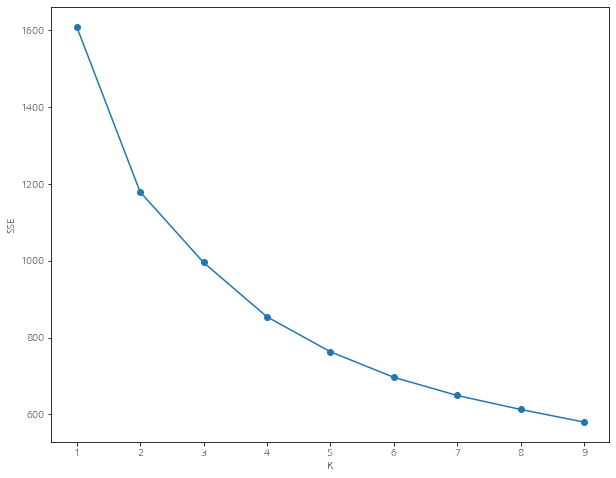

In [ ]:
sse = []
for i in range(1,10):
    km = KMeans(n_clusters=i, init='k-means++', random_state=0)
    km.fit(yz_data_val)
    sse.append(km.inertia_)
    
plt.figure(figsize = (10, 8))
plt.plot(range(1,10), sse, marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

Elbow Method를 이용하여 오차제곱합이 급격히 줄어드는 지점인 5를 K로 선택하였습니다.

In [ ]:
kmeans =KMeans(n_clusters=5).fit(yz_data_val)
yz_kmeans_drop['cluster']=kmeans.labels_
yz_kmeans_drop['cluster'].value_counts()

1    790
0    747
3    707
2    660
4    470
Name: cluster, dtype: int64

군집화 결과 각각 군집의 수가 대체로 균일하게 나뉜 것을 확인할 수 있습니다.

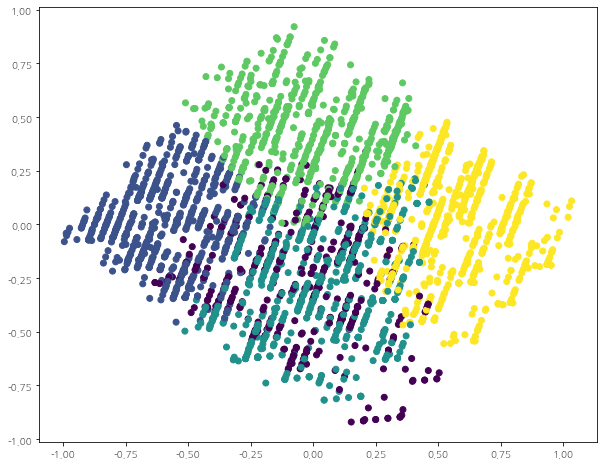

In [ ]:
#군집 시각화 (2차원)
pca = PCA(n_components = 2)
fit = pca.fit_transform(yz_data_val)
pca_data = pd.DataFrame(data = fit, columns = ['PC1', 'PC2'])

plt.figure(figsize = (10, 8))
plt.scatter('PC1', 'PC2', data = pca_data, c = kmeans.labels_)
plt.show()

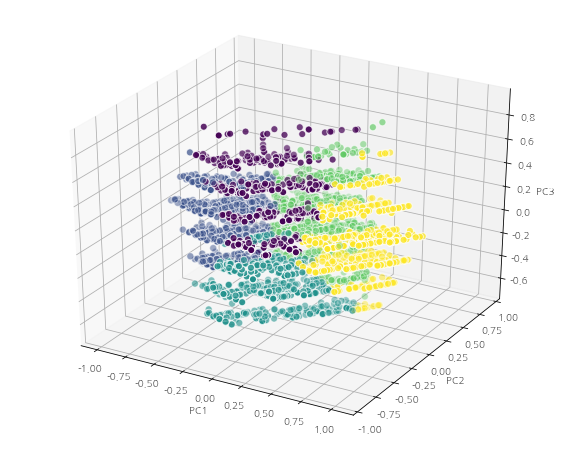

In [ ]:
#군집 시각화 (3차원)
pca3 = PCA(n_components=3)
data_pca3 = pca3.fit_transform(yz_data_val)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca3[:,0], data_pca3[:,1], data_pca3[:,2], c=kmeans.labels_, s=50, edgecolors='white')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

2차원, 3차원으로 차원축소하여 시각화 한 모습입니다.

## 3-4. Profiling

클러스터 순서는 저희가 서사에 알맞게 재구성 하였습니다.

In [ ]:
#기본 정보 출력 함수 
def show_basic_group_info(group_num):
  plt.rcParams['figure.figsize'] = [16, 11]
  plt.subplot(221)
  sns.countplot( yz_info[yz_info.index.isin(yz_kmeans_drop[yz_kmeans_drop['cluster']==group_num].index)]['sex_dit_cd'] )
  plt.xlabel("성별",size = 13)
  plt.ylabel("명",size = 13)
  plt.subplot(222)
  sns.countplot( yz_info[yz_info.index.isin(yz_kmeans_drop[yz_kmeans_drop['cluster']==group_num].index)]['cus_age'].sort_values() )
  plt.xlabel("나이",size = 13)
  plt.ylabel("세",size = 13)
  plt.subplot(223)
  sns.countplot( yz_info[yz_info.index.isin(yz_kmeans_drop[yz_kmeans_drop['cluster']==group_num].index)]['tco_cus_grd_cd'].sort_values() )
  plt.xlabel("등급",size = 13)
  plt.ylabel("명",size = 13)
  plt.subplot(224)
  sns.countplot( yz_info[yz_info.index.isin(yz_kmeans_drop[yz_kmeans_drop['cluster']==group_num].index)]['ivs_icn_cd'].sort_values() )
  plt.xlabel("투자성향",size = 13)
  plt.ylabel("명",size = 13)
  plt.show()

### 3-4-1. 평범한 월급쟁이형

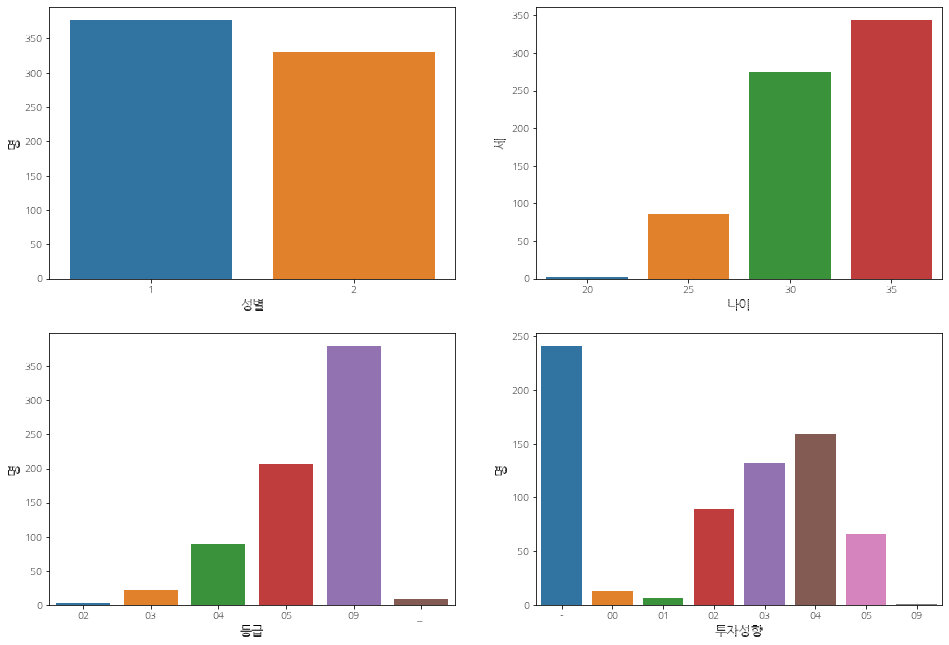

In [ ]:
#group3
show_basic_group_info(3)

### Group1 # **평범한 월급쟁이형**
  
평균나이 31세. <br>

계좌를 개설한지 4년 가까이 되는 이 OB들은 평균 체결 규모 39만원으로 꽤 소소한 투자를 실천중으로 <br>
재태크에 관해선 꽤나 관심이 있는 분들이라고 할 수 있습니다.<br>

분할매수, 매도 기법에 대해 나름 실천중이면서 대형주에 관심이 아주 많고, 배당의 쏠쏠함도 잘 아시는 분들입니다. <br>
남녀 성비는 유사하며 고객등급은 '등급없음'이 압도적으로 평범한 서민층 30대 투자자로 예상됩니다. <br>

가정을 꾸리고 자녀 양육비를 위한 목돈 마련이 시급한 만큼 적극적인 투자 성향을 지니고 있는 Group입니다.

### 3-4-2. 성공한 직장인형

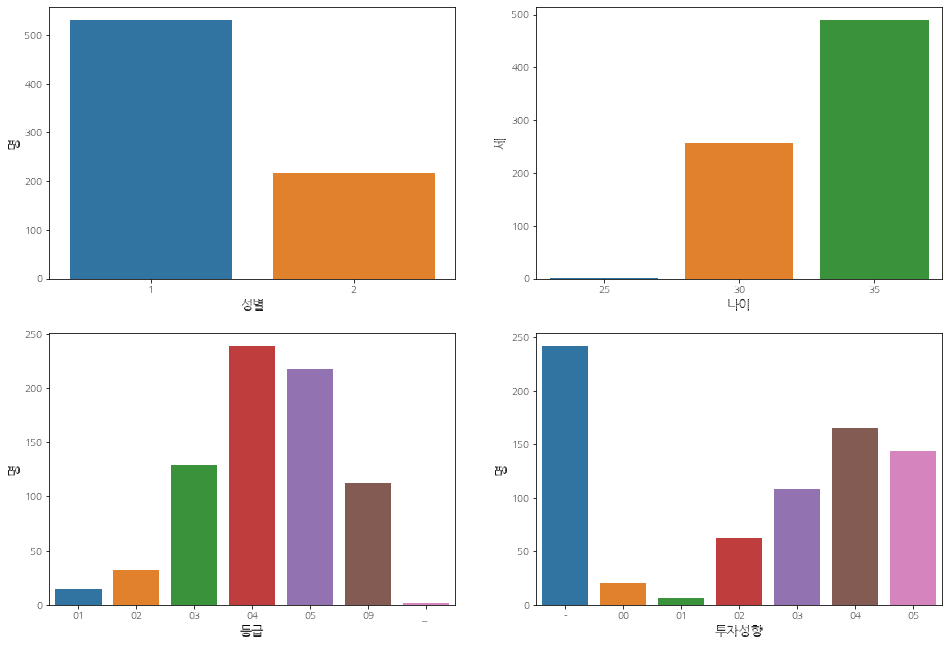

In [ ]:
#group0
show_basic_group_info(0)

###Group 2 # **성공한 직장인형**

평균나이 33세.<br>

 계좌 개설일이 5년 이상으로 가장 오래된 이 집단은 평균 체결규모가 583만원, <br>
 고객 등급 또한 '그린', 그 다음으로 '블루', '로얄'의 양상을 띄는 중산층의 투자자 집단입니다. <br>

 배당주엔 꽤나 관심을 보이지만 대형주나 해외주식엔 크게 흥미없어 하시네요.<br>

'# 평범한 월급쟁이' 유형과 마찬가지로 적극적인 30대 투자자들의 특성을 잘 보여주네요.<br>

다만, 성비에 있어서 남성이 여성보다 2배 가까이 많다는 것이 조금 흥미로운 사실이네요. 

### 3-4-3. 야무진 금수저 대학생형

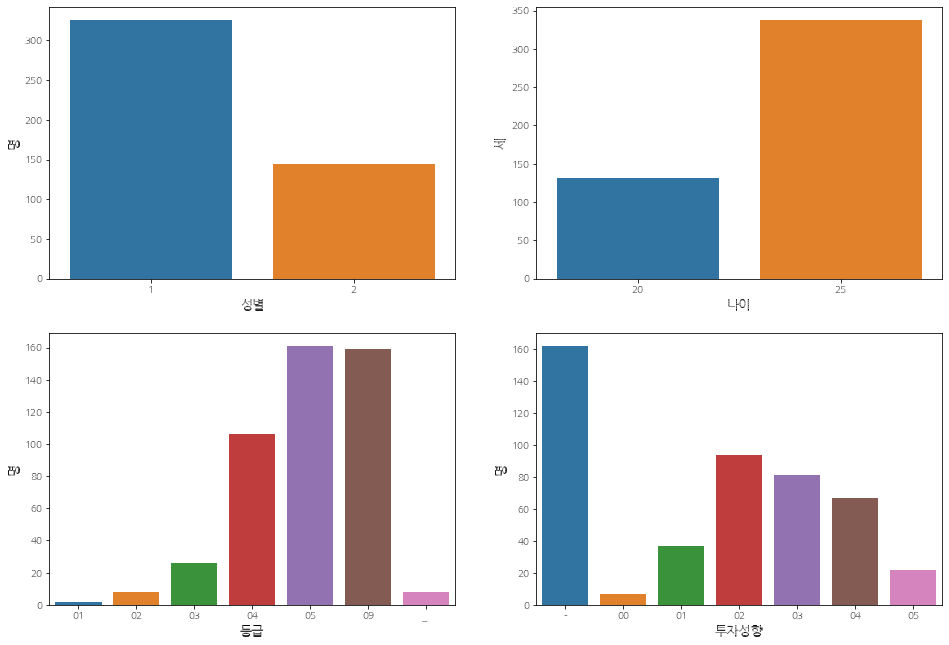

In [ ]:
#group4
show_basic_group_info(4)

### Group 3 # **야무진 금수저 대학생형**

평균 나이 23세<br>

제법 어린 연령층이지만, 평균 체결규모는 약 339만원으로 나이대 대비 꽤 큰 손의 group. <br>

계좌 개설일은 평균 2년 이상으로 코로나 이후 새롭게 유입된 투자자로 보기는 어려우며 <br>
배당주를 선호하고 남성투자자 비율이 여성투자자와 월등하게 차이난다는 점에서<br>
'# 성공한 직장인형'과 유사합니다.<br>

다만, 연령대가 어린만큼 Y&Z세대의 대표 투자성향('안정추구형')을 따라간다는 점에서 다른 그룹과 구분되네요.

### 3-4-4. 코로나 뉴비형(대학생ver.)

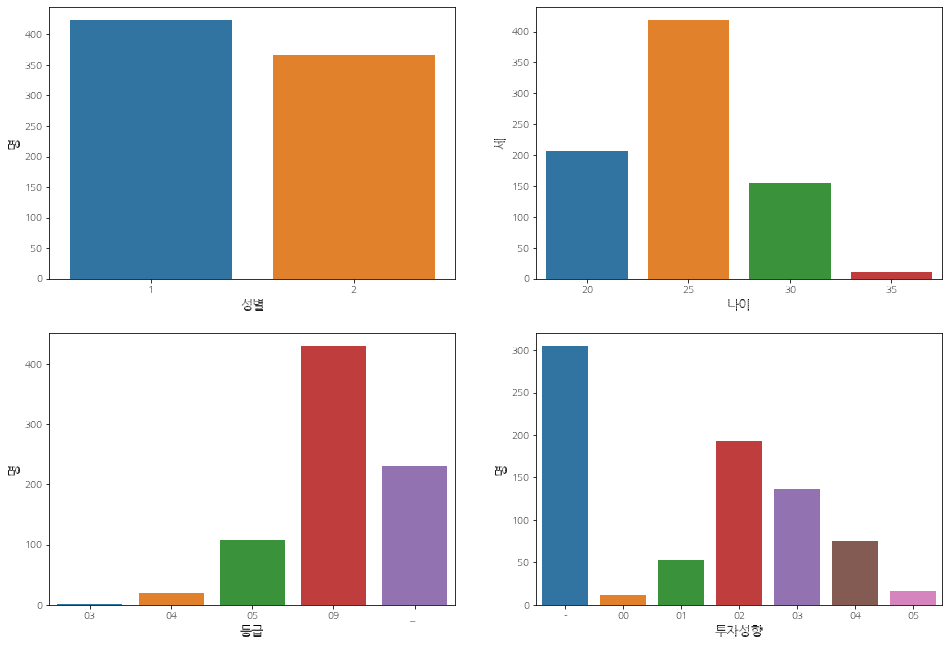

In [ ]:
#group1
show_basic_group_info(1)

### Group 4 # **코로나 뉴비형(대학생ver.)**

평균나이 24세<br>

코로나발 주식 열풍으로 인한 新 유입층의 정석, 교과서와 같은 group입니다.<br>

20대 초~중반이 대거 분포하며 체결규모는 36만원, 현실적인 대학생의 투자비용이라 생각됩니다.<br>

평균 계좌개설일이 150일로 2020년 들어 많이 유입되었음을 보여주고,<br>
해외 주식 선호도가 가장 높다는 점, 고객 등급 분포가 압도적으로 '등급없음'이 많다는 점,<br>
 '위험 중립형'&'안정 추구형'의 보수적인 투자성향을 띈다는 점에서 <br>
 Y&Z세대의 통합적인 특성을 가장 잘 대변해주는 group이라 할 수 있습니다.

### 3-4-5. 코로나 뉴비형(직장인ver.)

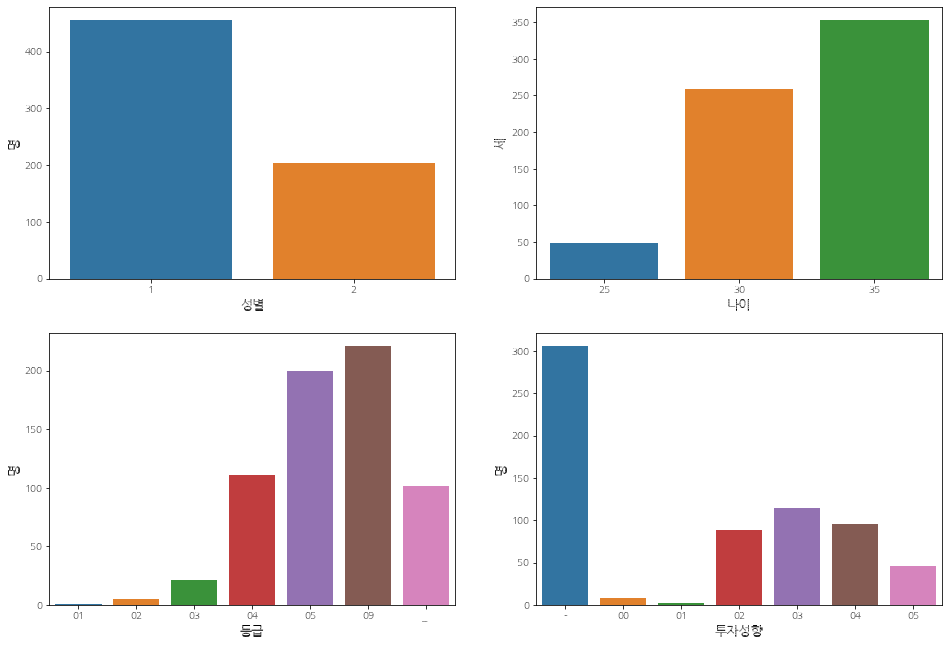

In [ ]:
#group2
show_basic_group_info(2)

### Group 5# **코로나 뉴비형(직장인ver.)**

평균나이는 32세<br>

코로나발 주식 열풍을 탄 뉴비가 대학생만 있으라는 법은 없습니다.<br>

 이미 사회진입을 이미 한  세대겠으나, 평균 계좌개설일은 125일로 이들 역시 新 유입층의 한 바람이라 할 수 있습니다.<br>

성비는 대표본과 유사하게 남여 2:1을 따르고 있습니다.<br>

 하지만 이들은 무지에서 비롯한 보수적 투자성향에도 불구하고, 323만원 규모의 큰 체결규모를 가지고 있습니다.<br>

분할매수/분할매도도 하지 않고 대형주, 배당주, 해외주식에도 관심이 없습니다.<br>

# 4. 결론

## 제안 솔루션과 한계


> 서론에서 언급했다시피, 결국 우리는 기존의 고객투자성향은 고객 자신을 정확히 설명하지 못하는 지표라 생각합니다.<br><br>
그리하여 투자성향을 배제하고 고객의 거래정보를 이용해 계량적인 정보로 그룹화하여<br>
 투자자가 한눈에 본인을 돌아볼 수 있는 새로운 고객성향 추천시스템을 제안합니다. <br><br>
우리 솔루션을 통해 투자자 본인이 더욱 자신을 잘 알아 현명한 투자를 할 수 있게 되고,<br> 
맞춤형 서비스 제안을 통해 고객 유인과 브랜드 이미지 제고에 기여할 것이라 기대합니다.<br><br>
본 연구를 진행하는 과정에서 투자자성향을 clustering할 수 있는 특징들을 제한적으로 적용하여<br> 
제한된 투자성향 그룹만을 묘사 할 수 밖에 없던 점이 저희 시도의 한계라고 생각됩니다. <br><br>
이러한 한계점을 극복하기 위해 더욱 follow-up하여 투자자를 잘 설명할 수 있도록 개선하겠습니다.<br><br>
 감사합니다.